In [2]:
import covfunctions
from gapp import gp,dgp
from gapp import covariance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [3]:
data = pd.read_csv("hubble_corrected.csv")
z = data['z'].values
hp = data['H_value'].values
herr = data['H_error'].values


In [4]:
zmin = 0.
zmax = 2.5
g1 = gp.GaussianProcess(z,hp,herr,covfunction=covariance.Matern32,cXstar=(zmin,zmax,200))
zr = z.reshape(-1,1)
g1d = dgp.DGaussianProcess(zr, hp, herr, covfunction=covariance.Matern32, cXstar=(zmin, zmax, 200))
print (g1d)

In [5]:
rec1, theta1 = g1d.gp()
drec, theta = g1d.dgp()


Optimized hyperparameters:
theta = [137.78082337   4.08956372]

Optimized hyperparameters:
theta = [137.78090144   4.08956816]


In [6]:
zrec = rec1[:,0]
hzrec = rec1[:,1]
sighzrec = rec1[:,2]


In [7]:
dzrec = drec[:,0]
dhzrec = drec[:,1]
dsighzrec = drec[:,2]

In [8]:
    print ('z=', zrec[0], ' H0=', hzrec[0], ' sigH0=',  sighzrec[0], ' sigH0/H0 (%)=', (sighzrec[0]/hzrec[0])*100)

z= 0.0  H0= 68.76140272287034  sigH0= 6.298861322944726  sigH0/H0 (%)= 9.160460772347939


<Figure size 640x480 with 0 Axes>

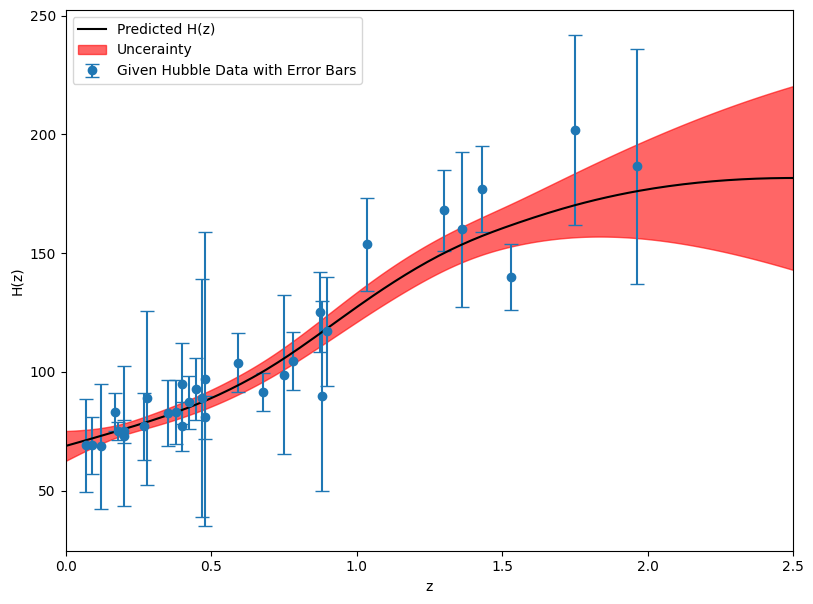

In [9]:
plt.clf()
plt.figure(figsize=(8, 6))
plt.xlim(0, 2.5)
plt.tight_layout()
plt.xlabel('z')
plt.ylabel("H(z)")
plt.errorbar(z, hp, yerr=herr, fmt='o', capsize=5, label="Given Hubble Data with Error Bars")
plt.plot(zrec, hzrec, 'k-', label="Predicted H(z)")
plt.fill_between(zrec, hzrec+1.*sighzrec, hzrec-1.*sighzrec, color='red', alpha=0.60, interpolate=True, label ='Uncerainty')
plt.legend() 
plt.show()
#plt.savefig('Hubble.png', dpi=300, bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

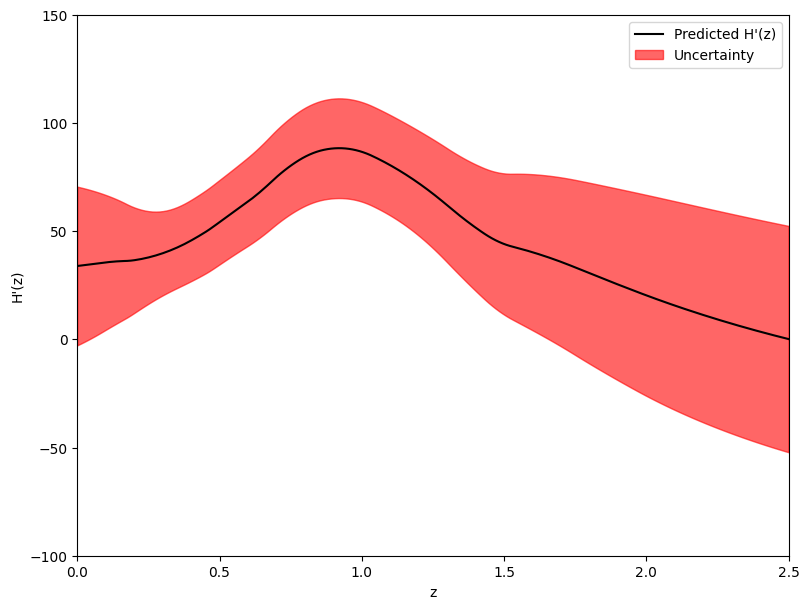

In [10]:
plt.clf()
plt.figure(figsize=(8, 6))
plt.xlim(0, 2.5)
plt.ylim(-100,150)
plt.tight_layout()
plt.xlabel('z')
plt.ylabel("H'(z)")
plt.plot(dzrec, dhzrec, 'k-', label="Predicted H'(z)")
plt.fill_between(dzrec,dhzrec+1.*dsighzrec, dhzrec-1.*dsighzrec, color='red', alpha=0.60, interpolate=True,label ="Uncertainty")
plt.legend() 
#plt.savefig('Hubble Derivative.png', dpi=300, bbox_inches='tight')

In [11]:
cmdc = pd.read_excel("A118.xlsx")
cmdc.head()
cmdi= cmdc[cmdc['z'] < 1.965].copy()
cmd = cmdi.sort_values('z').reset_index(drop=True)
print(cmd)

        GRB       z           Ep (keV) S bolo (10^-5 erg/cm^2)
0   130427A  0.3399      294.25 ± 5.86            31.72 ± 0.20
1   130831A  0.4800       81.35 ± 5.92             1.29 ± 0.07
2     91127  0.4900       60.32 ± 1.93             2.25 ± 0.04
3    100621  0.5400      146.49 ± 23.9             5.75 ± 0.64
4     90424  0.5440      236.91 ± 4.55             5.72 ± 0.09
5    130215  0.6000    247.54 ± 100.61             4.84 ± 0.12
6   131231A  0.6439      370.15 ± 4.97            17.42 ± 0.12
7    111209  0.6800     519.87 ± 88.88            69.47 ± 8.72
8     90328  0.7360    1221.71 ± 81.87             7.99 ± 0.20
9   150514A  0.8070     137.84 ± 14.93             0.71 ± 0.03
10   110715  0.8200     218.40 ± 20.93             2.73 ± 0.24
11  091003A  0.8969     857.81 ± 33.08             4.43 ± 0.08
12  091208B  1.0630     202.63 ± 20.10             0.75 ± 0.04
13  130701A  1.1600      191.80 ± 8.62             0.46 ± 0.04
14  160509A  1.1700  19334.10 ± 652.25            49.91

In [12]:
cmd['z'] = pd.to_numeric(cmd['z'], errors='coerce')
za = cmd['z']
zall = np.array(za)

In [13]:
Ep = cmd['Ep (keV)'].str.split(' ± ').str[0].astype(float)
Eperr = cmd['Ep (keV)'].str.split(' ± ').str[1].astype(float)
Sboloo = cmd['S bolo (10^-5 erg/cm^2)'].str.split(' ± ').str[0].astype(float)
Sberro = cmd['S bolo (10^-5 erg/cm^2)'].str.split(' ± ').str[1].astype(float)
Sbolo = (Sboloo*1e-5)
Sberr = (Sberro*1e-5)

In [14]:
g2 = gp.GaussianProcess(z,hp,herr,covfunction=covariance.Matern32,Xstar=zall)

In [15]:
yp,siga = g2.gp()



Optimized hyperparameters:
theta = [137.78082337   4.08956372]


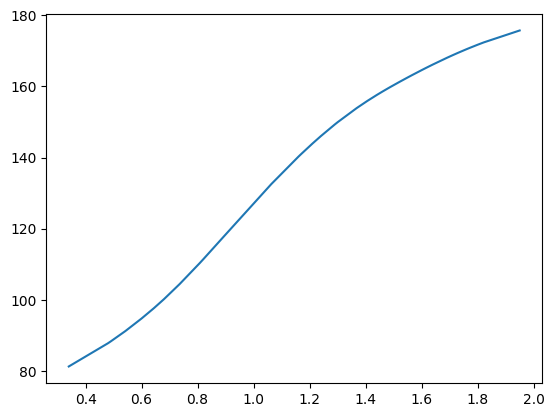

In [16]:
hzc = yp[:,1]
sigc = yp[:,2]
plt.plot(zall,hzc)

In [17]:
from scipy.integrate import simpson

c = 3e5  # km/s
def dL_gp(zall, zrec, hzrec, sighzrec):
    dL_cm = []
    sigma_dL = []

    for z in zall:
        mask = zrec <= z
        zi = zrec[mask]
        Hi = hzrec[mask]
        sigHi = sighzrec[mask]

        invH = 1 / Hi
        integral = simpson(y=invH, x=zi)
        dL = (1 + z) * c * integral * 3.086e24  # convert to cm
        dL_cm.append(dL)

        # Error propagation: σ(1/H) = σ_H / H^2
        sig_invH = sigHi / (Hi ** 2)
        var_integral = simpson(y=sig_invH**2, x=zi)
        sigma_dL_z = (1 + z) * c * np.sqrt(var_integral) * 3.086e24
        sigma_dL.append(sigma_dL_z)

    return np.array(dL_cm), np.array(sigma_dL)

In [18]:
#luminisoity diatnce of cmb data
dlc,sigdlc = dL_gp(zall, zrec, hzrec, sighzrec)

In [21]:
dlm = dlc/3.086e24
sigdlm = sigdlc/3.086e24
mu = 5 * np.log10(dlm) + 25
sigma_mu = 5 / np.log(10) * (sigdlm / dlm)
out = np.column_stack((zall, mu, sigma_mu))
np.savetxt("Hubbledist.csv", out, delimiter=",", header="z,mu,sigma_mu", comments="")

In [47]:
#dlc = dl * 3.086e24 #dl to be converted form MPC of hubble parameter to cm
eprest = Ep * (1 + zall)  # Convert to rest-frame
Eiso = 4*np.pi  * (dlc**2) *Sbolo/(1+zall)
xi = np.log10(eprest/300)
yi = np.log10(Eiso)
sigma_xi = Eperr / (np.log(10) * eprest)
sigma_Eiso = Eiso * np.sqrt((2 * sigdlc / dlc)**2 + (Sberr/ Sbolo)**2)
sigma_yi = sigma_Eiso / (np.log(10) * Eiso) 
print(yi)

0     52.975543
1     51.895536
2     52.159879
3     52.637760
4     52.654250
5     52.663043
6     53.290276
7     53.941169
8     53.066061
9     52.098933
10    52.697242
11    52.982872
12    52.351887
13    52.213136
14    54.256839
15    52.988000
16    54.478811
17    52.656042
18    52.880305
19    53.756384
20    54.625697
21    52.348014
22    52.867780
23    52.928320
24    53.910629
25    51.922368
26    53.114306
27    53.573465
28    53.327189
29    53.909461
30    52.115036
31    53.863163
32    54.366167
33    53.538863
34    53.184686
35    53.259203
36    53.234762
37    53.363284
38    53.533447
39    51.909558
40    53.426861
41    53.540053
42    53.851649
43    53.863129
44    53.216982
45    52.553581
46    54.512842
47    53.153616
Name: S bolo (10^-5 erg/cm^2), dtype: float64


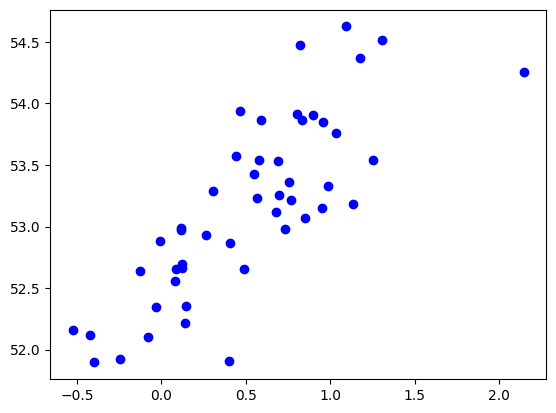

In [49]:
plt.scatter(xi, yi, color='blue', marker='o')

In [50]:
import emcee
import corner

# Define Log-Likelihood Function
def log_amati_likelihood(theta, xi, yi, sigma_xi, sigma_yi):
    
    a, b, sigma_ext = theta  

    # Total uncertainty (including intrinsic scatter)
    sigma_tot_i = np.sqrt(sigma_ext**2 + sigma_yi**2 + (b**2) * sigma_xi**2)
    
    # Log-likelihood calculation
    residuals = yi - (a + b * xi)
    log_likelihood = -0.5 * np.sum((residuals ** 2) / sigma_tot_i**2 + np.log(2 * np.pi * sigma_tot_i**2))
    
    return log_likelihood

# Define Priors
def log_prior(theta):
    a, b, sigma_ext = theta
    if 50 < a < 60 and 0.5 < b < 1.5 and 0 < sigma_ext < 5:
        return 0.0  # Uniform prior
    return -np.inf  # Log of zero probability

# Log-Probability Function (Log Prior + Log Likelihood)
def log_probability(theta, xi, yi, sigma_xi, sigma_yi):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_amati_likelihood(theta, xi, yi, sigma_xi, sigma_yi)


# MCMC Setup
n_walkers = 32
n_dim = 3  # Parameters: a, b, sigma_ext
np.random.seed(42)

# Initialize Walkers
initial = np.array([55, 1.0, 2.0])  # Initial guess for (a, b, sigma_ext)
pos = initial + 1e-4 * np.random.randn(n_walkers, n_dim)

# Set up the sampler
sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_probability, args=(xi, yi, sigma_xi, sigma_yi))

# Run MCMC
n_steps = 20000
sampler.run_mcmc(pos, n_steps, progress=True)

# Extract Samples
samples = sampler.get_chain(discard=1000, thin=10, flat=True)
a_fit, b_fit, sigma_ext_fit = np.median(samples, axis=0)

# Print Results
print(f"Best fit: a = {a_fit:.3f}, b = {b_fit:.3f}, sigma_ext = {sigma_ext_fit:.3f}")

100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [23:23<00:00, 14.25it/s]


Best fit: a = 52.590, b = 1.115, sigma_ext = 0.437


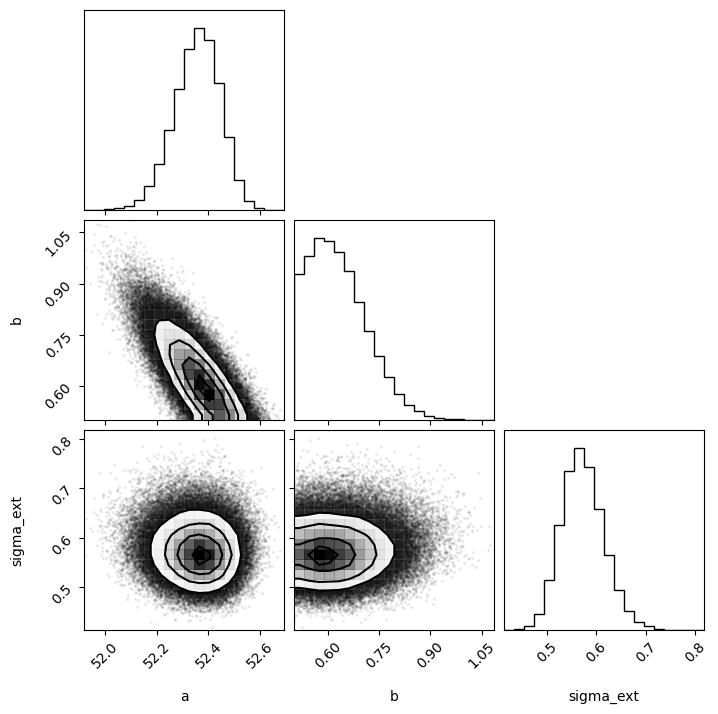

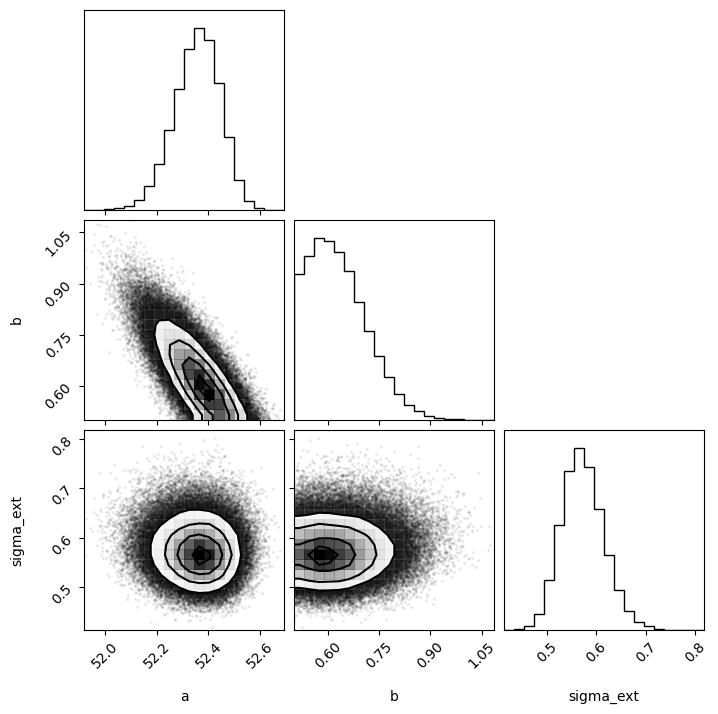

In [27]:
corner.corner(samples, labels=["a", "b", "sigma_ext"])
